# Preparation

In [1]:
#!git clone https://github.com/facebookresearch/detr

In [2]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
#import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion, DETR
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

#added
import json
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from numpy.random import rand, randint, ranf, randn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torchvision.transforms.functional as tf
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)
%matplotlib inline

/home/takeshi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

# Preparing the Data
## KITTI

In [4]:
from  IPython.display import Image as ipImage
ipImage("../doc/KITTI_coordinate.png")

FileNotFoundError: No such file or directory: '../doc/KITTI_coordinate.png'

FileNotFoundError: No such file or directory: '../doc/KITTI_coordinate.png'

<IPython.core.display.Image object>

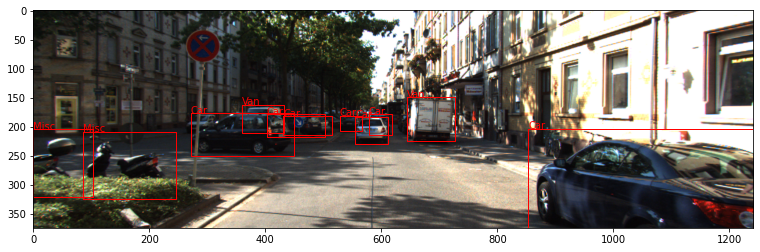

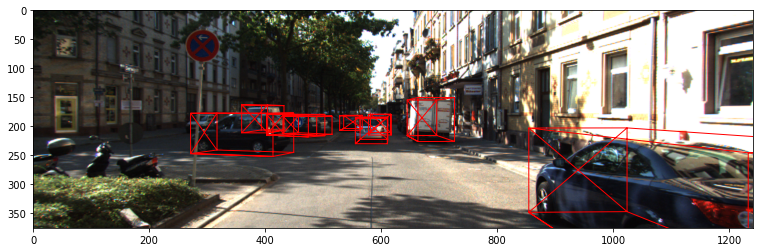

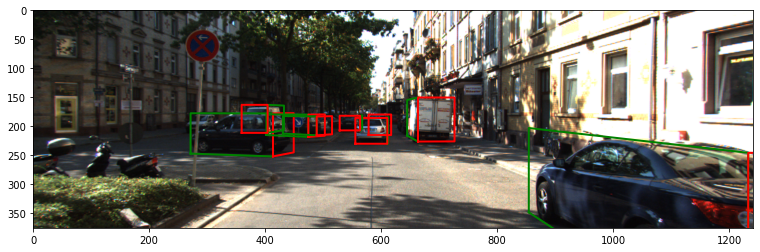

In [5]:
class KITTIData():
    def __init__(self, KITTIPath=None):
        if not KITTIPath==None:
            self.dataset_path = KITTIPath
        else:
            self.dataset_path = "../../../Dataset/KITTI/training/"
        self.img_folder_path = self.dataset_path + "image_2/"
        self.label_folder_path = self.dataset_path + "label_2/"
        self.calib_folder_path = self.dataset_path + "calib/"
        
        self.img_names = glob(self.img_folder_path + "*.png")
        for i in range(len(self.img_names)):
            self.img_names[i] = self.img_names[i].split('/')[-1][:-4]
        
        #print("Preparing", len(self.img_names), "images from KITTI.")
        #
        #self.annotations_list = pd.DataFrame()
        #names = ["type", "truncated", "occluded", "alpha", "left", "top", "right", "bottom",
        #         "height", "width", "length", "x", "y", "z", "rotation_y", ]
        #
        #for img_name in tqdm(self.img_names):
        #    label_path = self.label_folder_path + img_name + ".txt"
        #    annotations = pd.read_csv(label_path, names = names, sep='\s+')
        #    annotations["img_name"] = img_name
        #    self.annotations_list = self.annotations_list.append(annotations)
        #self.annotations_list = self.annotations_list[["img_name"]+names]
        #
        #print("Loading completed!")
        self.annotation_items = ["type", "truncated", "occluded", "alpha", "left", "top", "right", "bottom",
                                 "height", "width", "length", "x", "y", "z", "rotation_y", ]
        
    def __len__(self):
        return len(self.img_names)
        
    def line2P(self, l):
        P_elem = l.split()[1:]
        P = np.array(P_elem, dtype=np.float).reshape(3,-1)
        return P
    
    def readCalib(self, calib_name):
        calib_name = self.calib_folder_path + calib_name + ".txt"
        with open(calib_name) as f:
            P0 = self.line2P(f.readline())
            P1 = self.line2P(f.readline())
            P2 = self.line2P(f.readline())
            P3 = self.line2P(f.readline())
            R0_rect = self.line2P(f.readline())
            Tr_velo_to_cam = self.line2P(f.readline())
            Tr_imu_to_velo = self.line2P(f.readline())
        return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo
    
    def getPILImg(self, img_name):
        img_path = self.img_folder_path + img_name + ".png"
        img = Image.open(img_path)
        return img
    
    def getAnnotation(self, img_name):
        #return self.annotations_list[self.annotations_list["img_name"]==img_name]
        label_path = self.label_folder_path + img_name + ".txt"
        annotation = pd.read_csv(label_path, names=self.annotation_items, sep='\s+')
        annotation["img_name"] = img_name
        return annotation
    
    def plot2Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        for _, anno in annotations.iterrows():
            _type,left,top,right,bottom = anno["type"],anno["left"],anno["top"],anno["right"],anno["bottom"]
            plt.plot([left,right,right,left,left],
                     [top,top,bottom,bottom,top],
                     color="r",linewidth=1
                )
            plt.text(left, top, _type, color="r")

    def calcSurcfaceAngle(self, pts3D):
        """
        return belows. Element of each list is [front, right, back, left]
        - list of cos(angle) for each surface
        """
        # 直方体の8点から、隠れた点を除いて出力する
        face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                              [0,1,1,0,0,1,1,0], # right
                              [0,0,1,1,0,0,1,1], # back
                              [1,0,0,1,1,0,0,1]  # left
                             ])
        # 直方体の8点から、隠れた点を除いて出力する
        # face_idx = np.array([[0,1,5,4], # front face
        #                      [1,2,6,5], # right face
        #                      [2,3,7,6], # back face
        #                      [3,0,4,7]]) # left face
                             
        # 直方体の中心位置を計算
        c_rectangular = np.sum(pts3D, axis=1)/8
    
        # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
        cosForSfcs = []
        for i in range(4):
            p_in_plane = pts3D * face_mask[i] # 平面の4つの頂点
            c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
            normal = c_plane - c_rectangular# 平面の法線ベクトル
            c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
            
            # cosを計算して保存
            cos = np.dot(c_to_O, normal)/np.linalg.norm(c_to_O)/np.linalg.norm(normal)
            cosForSfcs.append(cos)
            # 面の頂点を保存
            #ptsForSfcs.append(pts3D[:,face_idx[i]])
        return cosForSfcs
    
    def projectToImage(self, pts3D, P):
        P = np.array(P)
        
        ones = np.ones([1,pts3D.shape[1]])
        pts3D = np.append(pts3D, ones, axis=0)
        pts2D = np.dot(P, pts3D)
        pts2D[0] /= pts2D[2]
        pts2D[1] /= pts2D[2]
        pts2D = np.delete(pts2D, obj=2, axis=0)
        return pts2D
    
    def calc3Dcoord(self, obj, P):
        # 直方体の各頂点のxyz座標を計算
        face_idx = np.array([[0,1,5,4], # front face
                             [1,2,6,5], # right face
                             [2,3,7,6], # back face
                             [3,0,4,7]]) # left face
        ry = obj["rotation_y"]
        R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                      [          0, 1,          0],
                      [-np.sin(ry), 0, np.cos(ry)]],
                     dtype=np.float)
        l = obj["length"]
        w = obj["width"]
        h = obj["height"]
        corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                            [0,0,0,0,-h,-h,-h,-h],
                            [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                           dtype=np.float).reshape(3,-1)
        pts3D = np.dot(R,corners)
        xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
        pts3D += xyz
        return pts3D
    
    def devideToEachSurface(self, pts):
        # 直方体の各頂点のxyz座標を計算
        face_idx = np.array([[0,1,5,4], # front face
                             [1,2,6,5], # right face
                             [2,3,7,6], # back face
                             [3,0,4,7]]) # left face
        
        ptsForSfcs = []
        for i in range(4):
            ptsForSfcs.append(pts[:,face_idx[i]])

        return ptsForSfcs
    
    def calcPseudo3Dbb(self, obj, P):
        """
        return belows. if any surface is unvisible, each array stores np.nans
        - 4 corners of front or back surface as np.array shaped 2x4
        - 4 corners of left or right surface as np.array shaped 2x4
        - cos angle of front or back surface
        - cos angle of left or right surface
        """
        pts3D = self.calc3Dcoord(obj, P)
        pts2D = self.projectToImage(pts3D, P)
        pts2D_devided = self.devideToEachSurface(pts2D)
        cosForSfcs = self.calcSurcfaceAngle(pts3D)

        # 返り値の変数を用意、デフォルト値を設定
        pts2D_fr = np.zeros([2,4])
        pts2D_fr[:,:] = np.nan
        pts2D_lr = pts2D_fr.copy()
        cos_fr, cos_lr = np.nan, np.nan
        
        # 見えている面を選ぶ
        for i in range(0,3,2):
            if cosForSfcs[i]>0:
                pts2D_fr = pts2D_devided[i]
                cos_fr = cosForSfcs[i]
                break
        for i in range(1,4,2):
            if cosForSfcs[i]>0:
                pts2D_lr = pts2D_devided[i]
                cos_lr = cosForSfcs[i]
                break
        # pts2D_fr, lrをx座標でソートする。下の順番になる
        # left-bottom, left-top, right-bottom, right-top
        pts2D_fr = pts2D_fr[:,pts2D_fr[0].argsort()].T
        pts2D_lr = pts2D_lr[:,pts2D_lr[0].argsort()].T
        
        return pts2D_fr, pts2D_lr, cos_fr, cos_lr
    
    def array2Pseudo3Dbb(self, pts2D_fr, pts2D_lr, cos_fr, cos_lr):
        coord = np.append(pts2D_fr, pts2D_lr).reshape([8,2])
        pose = np.append(cos_fr, cos_lr)
        obj = {"coord":coord,
               "pose":pose}
        return obj
    
    @staticmethod
    def psuedo3Dbb2ccwh(pts2D_fr, pts2D_lr=np.zeros([0,2])):
        """
        convert array to 2Dbb(cx, cy, w, h)
        """
        array2D = np.append(pts2D_fr, pts2D_lr)
        array2D = array2D[np.logical_not(np.isnan(array2D))].reshape([-1, 2])
        x0 = np.min(array2D[:,0])
        x1 = np.max(array2D[:,0])
        y0 = np.min(array2D[:,1])
        y1 = np.max(array2D[:,1])

        c_x, c_y = (x0+x1)/2, (y0+y1)/2
        w, h = x1-x0, y1-y0
        
        return [c_x, c_y, w, h]
    
    def compute3Dbb(self, obj, P):
        face_idx = np.array([[1,2,6,5], # front face
                             [2,3,7,6], # left face
                             [3,4,8,7], # back face
                             [4,1,5,8]]) # right face
        
        corner3D = self.calc3Dcoord(obj, P)
        if any(corner3D[2,:]<0.1): # 対象物の前後距離<.1だったら出力しない
            corner2D = []
        else:
            corner2D = self.projectToImage(corner3D, P)
        
        return corner2D, face_idx
    
    def plot3Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            corner2D, face_idx = self.compute3Dbb(anno, P2)
            if len(corner2D)==0:
                continue
            plt.plot(corner2D[0,[2,3,0,1,2,6,7,4,5,6,7,3,0,5,1,4,0]],
                     corner2D[1,[2,3,0,1,2,6,7,4,5,6,7,3,0,5,1,4,0]],
                     color="r",linewidth=1)
            # todo : 
            # plt.text(corner2D[0,0], corner2D[1,0]+10, "alpha : " + str(int(-anno["alpha"]/3.14*180)), color="green", size=15)
            
        plt.xlim([0,img.size[0]])
        plt.ylim([img.size[1],0])
    
    def plotPseudo3Dbb(self, img_name):
        annotations = self.getAnnotation(img_name)
        img = self.getPILImg(img_name)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            pts2D_fr, pts2D_lr, cos_fr, cos_lr = self.calcPseudo3Dbb(anno, P2)
            if cos_lr>0:
                plt.plot(pts2D_lr[[0,1,3,2,0],0],pts2D_lr[[0,1,3,2,0],1], "g", linewidth=2)
            if cos_fr>0:
                plt.plot(pts2D_fr[[0,1,3,2,0],0],pts2D_fr[[0,1,3,2,0],1], "r", linewidth=2)
            
        plt.xlim([0,img.size[0]])
        plt.ylim([img.size[1],0])

    #def __getitem__(self, idx):
    #    # Get data for pytorch
    #    # preprocess is done in self.getitem, and return except for gt
        # because batch process cannot treat not-fixed length
    #    img_name = self.img_names[idx]
    #    img = self.getPILImg(img_name)
    #    img = self.preprocessImage(img)
    #    
    #    # regularization of coordination
    #    targets = self.anno2listsObj(img_name)
    #    if len(targets["coords"])>0:
    #        targets["coords"] = torch.as_tensor(targets["coords"])
    #        targets["coords"] /= self.outSize
    #        targets["coords"] = targets["coords"].reshape([-1,16])
    #    else:
    #        targets["coords"] = torch.zeros([0,16]).float()
    #    targets["poses"] = torch.as_tensor(targets["poses"]).float()
    #    # todo : label設定する
    #    targets["labels"] = torch.zeros(targets["coords"].shape[-2]).long() # .shape[-1]はcoord数の16、.shape[-2]はlabel数
    #        
    #    # set bounding box for matching
    #    coords = targets["coords"].detach().numpy()
    #    bbox_normed = torch.as_tensor([self.psuedo3Dbb2ccwh(coord) for coord in coords], dtype=torch.float64).reshape([-1,4])
    #    targets["boxes"] = bbox_normed#*torch.as_tensor(np.append(self.outSize,self.outSize)) # アスペクト比を調整
    #    targets["boxes"] = targets["boxes"].float()
    #    targets["angles"] = torch.as_tensor(targets["angles"]).float()
    #    
    #    return img, targets

    
KITTIDataset = KITTIData()
i = 0
KITTIDataset.plot2Dbb(KITTIDataset.img_names[i])
KITTIDataset.plot3Dbb(KITTIDataset.img_names[i])
KITTIDataset.plotPseudo3Dbb(KITTIDataset.img_names[i])

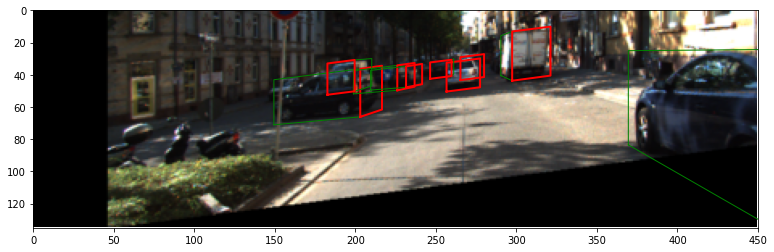

In [6]:
class ImagePreprocessor(KITTIData):
    def __init__(self, training=False, fliplr=False, shear_x=False, shear_y=False,
                 scale=False, crop=False, offset=False):
        super().__init__()
        
        self.training = training
        self.augFlags = {
            "fliplr":fliplr,
            "shear_x":shear_x,
            "shear_y":shear_y,
            "scale":scale,
            "crop":crop,
            "offset":offset
            }
        self.augParams = {
            "fliplr":False,
            "shear_x":0,
            "shear_y":0,
            "scale_x":1,
            "scale_y":1,
            "offset":[0,0]
            }
        self.outSize = np.array([450,135]) # x,y
        self.suppression_captureRate = .15
    
    def setAugParams(self, img):
        self.inSize = np.array(img.size) # x,y
        
        if self.training:
            if self.augFlags["fliplr"]:
                self.augParams["fliplr"] = rand()>.5
            if self.augFlags["shear_x"]:
                self.augParams["shear_x"] = (rand()-.5)*2*self.augFlags["shear_x"]
            if self.augFlags["shear_y"]:
                self.augParams["shear_y"] = (rand()-.5)*2*self.augFlags["shear_y"]
            if self.augFlags["scale"]:
                self.augParams["crop_x"] = randint((2*self.augFlags["scale"]-1)*self.inSize[0],self.inSize[0])
                self.augParams["crop_y"] = randint((2*self.augFlags["scale"]-1)*self.inSize[1],self.inSize[1])
                self.augParams["offset_x"] = randint(0,self.inSize[0]-self.augParams["crop_x"])
                self.augParams["offset_y"] = randint(0,self.inSize[1]-self.augParams["crop_y"])
    
    def preprocessImage(self, PILimg):
        img = PILimg
        self.setAugParams(img)
        
        if self.training:
            if self.augFlags["fliplr"] and self.augParams["fliplr"]:
                img = ImageOps.mirror(img)
            affined = tf.affine(img, angle=0,
                                    translate=(0,0),
                                    scale=self.augFlags["scale"],
                                    shear=[self.augParams["shear_x"],self.augParams["shear_y"]]
                                   )
            cropped = tf.crop(affined, self.augParams["offset_y"], self.augParams["offset_x"],
                              self.augParams["crop_y"], self.augParams["crop_x"])
        else:
            cropped = img
        resized = transforms.Resize(self.outSize[::-1])(cropped)
        resized = transforms.ToTensor()(resized)
        
        return resized
    
    def captured_rate(self, bb_ccwh, img_size):
        # determine the (x, y)-coordinates of the intersection rectangle
        c_x, c_y, w, h = bb_ccwh
        img_w, img_h = img_size[0], img_size[1]
        
        area_bb = w*h
        # intersection area
        x0 = max(0, c_x-w/2)
        x1 = min(img_w, c_x+w/2)
        y0 = max(0, c_y-h/2)
        y1 = min(img_h, c_y+h/2)
        area_intersection = (x1-x0)*(y1-y0)
        
        if x1<x0 or y1<y0:
            area_intersection = 0
        
        return area_intersection/(area_bb+.00001)
    
    def preprocessAnno(self, pts2D_fr, pts2D_lr, angle):
        array = np.append(pts2D_fr, pts2D_lr).reshape([8,2])
        # fliplr, scale, shear_x, shear_y, offset, crop
        if self.training:
            if self.augFlags["fliplr"] and self.augParams["fliplr"]:
                array[:,0] = self.inSize[0] - array[:,0]
                array[0:2,:],array[2:4,:],array[4:6,:],array[6:8,:] =\
                     array[2:4,:].copy(),array[0:2,:].copy(),array[6:8,:].copy(),array[4:6,:].copy()
                angle = np.pi - angle
            if self.augFlags["scale"]:
                array = array*self.augFlags["scale"] + self.inSize*(1-self.augFlags["scale"])/2
            if self.augFlags["shear_x"]:
                off_y = np.array(array[:,1]-self.inSize[1]/2)
                array[:,0] -= off_y*np.tan(self.augParams["shear_x"]/180*np.pi)
            if self.augFlags["shear_y"]:
                off_x = np.array(array[:,0]-self.inSize[0]/2)
                array[:,1] -= off_x*np.tan(self.augParams["shear_y"]/180*np.pi)
            if self.augFlags["scale"]:
                array -= np.array([self.augParams["offset_x"], self.augParams["offset_y"]])
                array *= self.outSize/np.array([self.augParams["crop_x"], self.augParams["crop_y"]])
        else:
            array *= self.outSize/self.inSize
        pts2D_fr = array[:4,:]
        pts2D_lr = array[4:,:]
        return pts2D_fr, pts2D_lr, angle
    
    def anno2objsList(self, img_name):
        # return list which contains objects
        annotations = self.getAnnotation(img_name)
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        objects = []
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            angle = -anno["alpha"]
            pts2D_fr, pts2D_lr, cos_fr, cos_lr = self.calcPseudo3Dbb(anno, P2)
            pts2D_fr_aug, pts2D_lr_aug, angle = self.preprocessAnno(pts2D_fr, pts2D_lr, angle)
            angle = (angle)%(2*np.pi)
            
            # 元画像に写っている面積が小さければ出力しない
            # 変換後の画像に写っている面積が小さければ出力しない
            bb2D_aug = self.psuedo3Dbb2ccwh(pts2D_fr_aug, pts2D_lr_aug)
            bb2D = self.psuedo3Dbb2ccwh(pts2D_fr, pts2D_lr)
            if self.captured_rate(bb2D, self.inSize)<self.suppression_captureRate:
                continue
            elif self.captured_rate(bb2D_aug, self.outSize)<self.suppression_captureRate:
                continue
            obj = self.array2Pseudo3Dbb(pts2D_fr_aug, pts2D_lr_aug, cos_fr, cos_lr)
            objects.append(obj)
        return objects
    
    def anno2listsObj(self, img_name):
        # return dictionary which contains lists of object informatation
        annotations = self.getAnnotation(img_name)
        _, _, P2, _, _, _, _ = self.readCalib(img_name)
        listObject = {"coords":[], "poses":[], "angles":[]}
        for _, anno in annotations.iterrows():
            #if anno["type"] == "DontCare":
            if not anno["type"] in ['Car', 'Van', 'Truck']:
                continue
            angle = -anno["alpha"]
            pts2D_fr, pts2D_lr, cos_fr, cos_lr = self.calcPseudo3Dbb(anno, P2)
            pts2D_fr_aug, pts2D_lr_aug, angle = self.preprocessAnno(pts2D_fr, pts2D_lr, angle)
            angle = (angle)%(2*np.pi)
            # 元画像に写っている面積が小さければ出力しない
            # 変換後の画像に写っている面積が小さければ出力しない
            bb2D_aug = self.psuedo3Dbb2ccwh(pts2D_fr_aug, pts2D_lr_aug)
            bb2D = self.psuedo3Dbb2ccwh(pts2D_fr, pts2D_lr)
            if self.captured_rate(bb2D, self.inSize)<self.suppression_captureRate:
                continue
            elif self.captured_rate(bb2D_aug, self.outSize)<self.suppression_captureRate:
                continue
            
            listObject["coords"].append(np.append(pts2D_fr_aug, pts2D_lr_aug).reshape([8,2]))
            listObject["poses"].append(np.append(cos_fr, cos_lr))
            listObject["angles"].append(angle)
        return listObject
    
    def plotPseudo3Dbb(self, img_name):
        img = self.getPILImg(img_name)
        img = self.preprocessImage(img)
        img = np.rollaxis(np.array(img),0,3)
        
        plt.figure(figsize=(15, 4))
        plt.imshow(img)
        
        objs = self.anno2objsList(img_name)
        for obj in objs:
            if not np.isnan(obj["pose"][1]):
                plt.plot(obj["coord"][[4,5,7,6,4],0],obj["coord"][[4,5,7,6,4],1], "g", linewidth=1)
            if not np.isnan(obj["pose"][0]):
                plt.plot(obj["coord"][[0,1,3,2,0],0],obj["coord"][[0,1,3,2,0],1], "r", linewidth=2)
        
        plt.xlim([0,img.shape[1]])
        plt.ylim([img.shape[0],0])

    def __getitem__(self, idx):
        # Get data for pytorch
        # preprocess is done in self.getitem, and return except for gt
        # because batch process cannot treat not-fixed length
        img_name = self.img_names[idx]
        img = self.getPILImg(img_name)
        img = self.preprocessImage(img)
        
        # regularization of coordination
        targets = self.anno2listsObj(img_name)
        if len(targets["coords"])>0:
            targets["coords"] = torch.as_tensor(targets["coords"])
            targets["coords"] /= self.outSize
            targets["coords"] = targets["coords"].reshape([-1,16]).float()
        else:
            targets["coords"] = torch.zeros([0,16]).float()
        targets["poses"] = torch.as_tensor(targets["poses"]).reshape([-1,2]).float()
        # todo : label設定する
        targets["labels"] = torch.zeros(targets["coords"].shape[-2]).long() # .shape[-1]はcoord数の16、.shape[-2]はlabel数
        targets["angles"] = torch.as_tensor(targets["angles"])
        targets["angles_c"] = torch.cos(targets["angles"]).reshape([-1,1]).float()
        targets["angles_s"] = torch.sin(targets["angles"]).reshape([-1,1]).float()
        del targets["angles"]
            
        # set bounding box for matching
        coords = targets["coords"].detach().numpy()
        bbox_normed = torch.as_tensor([self.psuedo3Dbb2ccwh(coord) for coord in coords]).reshape([-1,4]).float()
        targets["boxes"] = bbox_normed*torch.as_tensor([1,135/450]*2) # アスペクト比を調整
        return img, targets

vehicleAug = ImagePreprocessor(training=True, fliplr=True, shear_x=False, shear_y=10,
                 scale=0.7, crop=False, offset=False)
i = 0
vehicleAug.plotPseudo3Dbb(KITTIDataset.img_names[i])

targets :  {'coords': tensor([[0.3503, 0.6271, 0.3503, 0.5390, 0.3926, 0.6173, 0.3926, 0.5292, 0.3926,
         0.6173, 0.3926, 0.5292, 0.3933, 0.6021, 0.3933, 0.5257],
        [0.2415, 0.6958, 0.2415, 0.5487, 0.2689, 0.6755, 0.2689, 0.5415, 0.1327,
         0.7113, 0.1327, 0.5733, 0.2415, 0.6958, 0.2415, 0.5487],
        [0.2883, 0.6182, 0.2883, 0.5418, 0.3101, 0.6089, 0.3101, 0.5361, 0.2330,
         0.6245, 0.2330, 0.5536, 0.2883, 0.6182, 0.2883, 0.5418],
        [0.2993, 0.6101, 0.2993, 0.5455, 0.3196, 0.6020, 0.3196, 0.5400, 0.2547,
         0.6146, 0.2547, 0.5545, 0.2993, 0.6101, 0.2993, 0.5455],
        [0.3296, 0.5863, 0.3296, 0.5362, 0.3566, 0.5801, 0.3566, 0.5299, 0.3566,
         0.5801, 0.3566, 0.5299, 0.3594, 0.5731, 0.3594, 0.5276],
        [0.8692, 1.2360, 0.8692, 0.5379, 1.1756, 1.1509, 1.1756, 0.4644, 0.5794,
         0.8086, 0.5794, 0.5203, 0.8692, 1.2360, 0.8692, 0.5379],
        [0.4330, 0.6005, 0.4330, 0.4497, 0.4813, 0.5887, 0.4813, 0.4387, 0.4188,
         0.5834

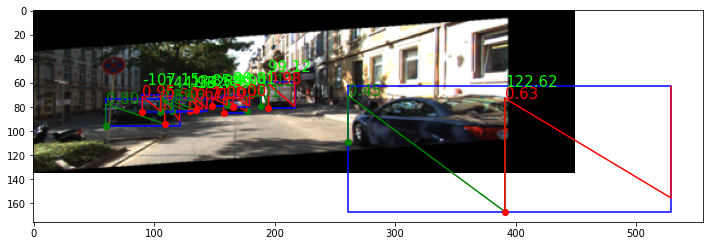

In [7]:
img, targets = vehicleAug[0]

plt.figure(figsize=(12,4))
plt.imshow(np.rollaxis(np.array(img),0,3))
FrontOrRear = targets["coords"][:,:8].reshape([-1,4,2])*torch.tensor([450,135])
LeftOrRight = targets["coords"][:,8:].reshape([-1,4,2])*torch.tensor([450,135])
pose = targets["poses"]
angle = torch.atan2(targets["angles_s"], targets["angles_c"])*180/3.1415
x0, x1 = targets["boxes"][:,0]-.5*targets["boxes"][:,2], targets["boxes"][:,0]+.5*targets["boxes"][:,2]
y0, y1 = targets["boxes"][:,1]-.5*targets["boxes"][:,3], targets["boxes"][:,1]+.5*targets["boxes"][:,3]
x0, x1, y0, y1 = x0*450, x1*450, y0*450, y1*450
for i in range(FrontOrRear.shape[0]):
    plt.plot([x0[i], x0[i], x1[i], x1[i], x0[i]], [y0[i], y1[i], y1[i], y0[i], y0[i]], "b")
    tmp = False
    if not torch.isnan(pose[i,1]):
        plt.plot(LeftOrRight[i,:,0], LeftOrRight[i,:,1], "g")
        plt.plot(LeftOrRight[i,0,0], LeftOrRight[i,0,1], "go")
        plt.text(LeftOrRight[i,1,0], LeftOrRight[i,1,1], '{:.2f}'.format(pose[i,1]), size=15, color="g")
    if not torch.isnan(pose[i,0]):
        plt.plot(FrontOrRear[i,:,0], FrontOrRear[i,:,1], "r")
        plt.plot(FrontOrRear[i,0,0], FrontOrRear[i,0,1], "ro")
        plt.text(FrontOrRear[i,1,0], FrontOrRear[i,1,1], '{:.2f}'.format(pose[i,0]), size=15, color="r")
        tmp = True
    if tmp:
        x, y = FrontOrRear[i,1,0], FrontOrRear[i,1,1]
    else:
        x, y, = LeftOrRight[i,1,0], LeftOrRight[i,1,1]
    plt.text(x, y-10, '{:.2f}'.format(angle[i,0]), size=15, color="lime")
print("targets : ", targets)

In [8]:
len(vehicleAug)

7481

# Creating Dataset

In [9]:
img_list = vehicleAug.img_names
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)
print("train dataset has ", len(train_list), "images.")
print("val dataset has ", len(val_list), "images.")

train dataset has  7106 images.
val dataset has  375 images.


In [10]:
class VehicleDataset(Dataset):
    def __init__(self, dataList, training=True):
        self.dataset = ImagePreprocessor(training=training, fliplr=True, shear_x=False, shear_y=10,
                                         scale=0.7, crop=False, offset=False)
        self.dataset.img_names = dataList
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [11]:
train_dataset = VehicleDataset(train_list, training=True)
val_dataset = VehicleDataset(val_list, training=False)

In [12]:
BATCH_SIZE = 16
num_worker = 4

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=num_worker)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=num_worker)

# Model

In [13]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=num_classes)
        self.model.pose_embed = nn.Linear(in_features=self.in_features,out_features=2)
        self.model.coord_embed = nn.Linear(in_features=self.in_features,out_features=16)
        self.model.box_embed = nn.Linear(in_features=self.in_features,out_features=4)
        self.model.angle_embed = nn.Linear(in_features=self.in_features,out_features=2)
        self.model.num_classes = num_classes
        self.model.num_queries = num_queries
        
        
        hidden_dim = self.model.transformer.d_model
        self.model.query_embed = nn.Embedding(num_queries, hidden_dim)
        
    def forward(self,images):
        ## from facebook/DETR
        if isinstance(images, (list, torch.Tensor)):
            images = nested_tensor_from_tensor_list(images)
        features, pos = self.model.backbone(images)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.model.transformer(self.model.input_proj(src), mask, self.model.query_embed.weight, pos[-1])[0]

        outputs_class = self.model.class_embed(hs)
        outputs_pose = self.model.pose_embed(hs)
        outputs_coord = self.model.coord_embed(hs)
        outputs_box = self.model.box_embed(hs)
        outputs_angle = self.model.angle_embed(hs)
        out = {'pred_logits': outputs_class[-1],
               'pred_poses': outputs_pose[-1],
               'pred_coords': outputs_coord[-1],
               'pred_boxes': outputs_box[-1],
               'pred_angles': outputs_angle[-1]}
        return out

# Matcher and Bipartite Matching Loss

In [14]:
matcher = HungarianMatcher()

weight_dict = {'loss_ce': 1, 'loss_poses': 1 , 'loss_coords': 1, 'loss_boxes': 1, 'loss_angles':.1}

losses = ['labels', 'poses', 'coords', 'boxes', 'angles']

# Evaluation Function

In [15]:
class SetVehicleCriterion(SetCriterion):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.poseThresh = .5
    
    @staticmethod
    def formatCcwh(ccwh):
        tmp = ccwh[:,2:4]
        tmp[tmp<0] = 0
        ccwh[:,2:4] = tmp
    
        return ccwh
    
    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes[idx] = target_classes_o
            
        
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        return losses
    
    def loss_poses(self, outputs, targets, indices, num_boxes):
        assert 'pred_poses' in outputs
        losses = {}

        idx = self._get_src_permutation_idx(indices)
        src_poses = outputs['pred_poses'].sigmoid()[idx]
        with torch.no_grad():
            target_poses = torch.cat([t['poses'][i] for t, (_, i) in zip(targets, indices)], dim=0)
            target_poses_bin = torch.logical_not(torch.isnan(target_poses)).float()
            lr = target_poses
            lr[torch.isnan(lr)] = 1 # use cos(angle) as training rate

        loss_poses = F.binary_cross_entropy(src_poses, target_poses_bin, reduction='none')
        losses['loss_poses'] = (loss_poses*lr).sum() / num_boxes
        
        return losses
    
    def loss_coords(self, outputs, targets, indices, num_boxes):
        assert 'pred_coords' in outputs
        losses = {}
        
        idx = self._get_src_permutation_idx(indices)
        src_coords = outputs['pred_coords'][idx]
        target_poses = torch.cat([t['poses'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        target_coords = torch.cat([t['coords'][i] for t, (_, i) in zip(targets, indices)], dim=0)
    
        loss_coords = F.l1_loss(src_coords, target_coords, reduction='none')
        
        loss_weight = torch.as_tensor([450, 135]*8)
        loss_coords = loss_coords*loss_weight
        loss_coords = torch.clamp(loss_coords,0,50) # 誤差が大きすぎるものはcliping
        loss_coords /= 450
        
        # もし車両の面が見えていなければ学習させない
        with torch.no_grad():
             # coordと同じshapeで重みが設定されたtensorを作成
            cos_weight = torch.stack([target_poses.reshape(-1) for _ in range(8)]).T.reshape([-1,16]).float()
             # 面が見えていない場合はcoordを学習させないためのmask
            loss_mask = torch.logical_not(torch.isnan(cos_weight)).bool()
        loss_coords = loss_coords[loss_mask]#*cos_weight[loss_mask]
    
        losses['loss_coords'] = loss_coords.sum() / num_boxes
        
        return losses
    
    def loss_angles(self, outputs, targets, indices, num_boxes):
        assert 'pred_boxes' in outputs
        losses = {}

        idx = self._get_src_permutation_idx(indices)
        src_angles = outputs['pred_angles'][idx]#.sigmoid()*2-1
        target_angles_c = torch.cat([t['angles_c'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        target_angles_s = torch.cat([t['angles_s'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_angles_s = F.l1_loss(src_angles[:,0].reshape(-1,1), target_angles_s, reduction='none')
        loss_angles_c = F.l1_loss(src_angles[:,1].reshape(-1,1), target_angles_c, reduction='none')

        losses['loss_angles'] = (loss_angles_s.sum()+loss_angles_c.sum()) / num_boxes
        
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        assert 'pred_boxes' in outputs
        losses = {}
        
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        #src_boxes = src_boxes*torch.as_tensor([1, 135/450]*2) # src_boxesの0~1が画像の縦横全体を表す
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)
    
        loss_boxes = F.l1_loss(src_boxes, target_boxes, reduction='none')
        #loss_boxes = torch.clamp(loss_boxes,0,20) # 誤差が大きすぎるものはcliping
    
        losses['loss_boxes'] = loss_boxes.sum() / num_boxes
        
        return losses

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'poses': self.loss_poses,
            'coords': self.loss_coords,
            'boxes': self.loss_boxes,
            'angles': self.loss_angles
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)
    
    def forward(self, outputs, targets):
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}
        boxes = outputs["pred_boxes"].detach().numpy()
        
        outputs_without_aux["pred_boxes"] =\
            torch.as_tensor([self.formatCcwh(ccwh) for ccwh in boxes])
        
        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

# Engine

In [16]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 30
null_class_coef = 0.5
LR = 2e-5
EPOCHS = 300

In [18]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetVehicleCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Using cache found in /home/takeshi/.cache/torch/hub/facebookresearch_detr_master


In [19]:
def setOptimizer(lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[70,140], gamma=0.1, last_epoch=-1)
    return optimizer, scheduler

optimizer, scheduler = setOptimizer(LR)

In [20]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch,history):
    
    model.train()
    criterion.train()
    
    total_loss = AverageMeter()
    labels_loss = AverageMeter()
    poses_loss = AverageMeter()
    coords_loss = AverageMeter()
    boxes_loss = AverageMeter()
    angles_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        
        total_loss.update(losses.item(),BATCH_SIZE)
        labels_loss.update(loss_dict['loss_ce'].item())
        poses_loss.update(loss_dict['loss_poses'].item())
        coords_loss.update(loss_dict['loss_coords'].item())
        boxes_loss.update(loss_dict['loss_boxes'].item())
        angles_loss.update(loss_dict['loss_angles'].item())
        tk0.set_postfix(total_loss=total_loss.avg,
                        labels=labels_loss.avg,
                        pose=poses_loss.avg,
                        coords=coords_loss.avg,
                        angles=angles_loss.avg,
                        boxes=boxes_loss.avg)
    
    if scheduler is not None:
        scheduler.step()
        
    history.loc[epoch, 'train_loss'] = total_loss.avg
    history.loc[epoch, 'loss_labels'] = labels_loss.avg
    history.loc[epoch, 'loss_poses'] = poses_loss.avg
    history.loc[epoch, 'loss_coords'] = coords_loss.avg
    history.loc[epoch, 'loss_boxes'] = boxes_loss.avg
    history.loc[epoch, 'loss_angles'] = angles_loss.avg
        
    return total_loss

In [21]:
def eval_fn(data_loader, model,criterion, device, epoch, history):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = data_loader
        #tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            #tk0.set_postfix(loss=summary_loss.avg)
            
    history.loc[epoch, 'val_loss'] = summary_loss.avg
    
    return summary_loss

In [22]:
for param in model.model.backbone.parameters():
    param.required_grad = False
best_map = np.inf
history = pd.DataFrame()

for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model,criterion, optimizer,device,scheduler=scheduler,epoch=epoch,history=history)
    eval_loss = eval_fn(val_loader, model,criterion, device, epoch, history)
    
    #valid_map_score = calculate_final_score(predictions,0.5,form='coco')

    print('|EPOCH {}| LEARNING RATE {:.0e}| TRAIN_LOSS {:.5f}| EVAL_LOSS {:.5f}|'.format(
        epoch+1,scheduler.get_lr()[0], train_loss.avg,eval_loss.avg))

    if eval_loss.avg < best_map:
        best_map = eval_loss.avg
        print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
        torch.save(model.state_dict(), '../model/0214_epoch{}_evalLoss{:.5f}.pth'.format(epoch+1,eval_loss.avg))


|EPOCH 1| LEARNING RATE 2e-05| TRAIN_LOSS 2.35367| EVAL_LOSS 1.82477|
Best model found in Epoch 1........Saving Model


/home/takeshi/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



|EPOCH 2| LEARNING RATE 2e-05| TRAIN_LOSS 1.84119| EVAL_LOSS 1.57269|
Best model found in Epoch 2........Saving Model



|EPOCH 3| LEARNING RATE 2e-05| TRAIN_LOSS 1.71348| EVAL_LOSS 1.42008|
Best model found in Epoch 3........Saving Model



|EPOCH 4| LEARNING RATE 2e-05| TRAIN_LOSS 1.66269| EVAL_LOSS 1.44184|



|EPOCH 5| LEARNING RATE 2e-05| TRAIN_LOSS 1.60354| EVAL_LOSS 1.44416|



|EPOCH 6| LEARNING RATE 2e-05| TRAIN_LOSS 1.55035| EVAL_LOSS 1.26438|
Best model found in Epoch 6........Saving Model



|EPOCH 7| LEARNING RATE 2e-05| TRAIN_LOSS 1.48929| EVAL_LOSS 1.30806|



|EPOCH 8| LEARNING RATE 2e-05| TRAIN_LOSS 1.47673| EVAL_LOSS 1.23855|
Best model found in Epoch 8........Saving Model



|EPOCH 9| LEARNING RATE 2e-05| TRAIN_LOSS 1.43114| EVAL_LOSS 1.39090|



|EPOCH 10| LEARNING RATE 2e-05| TRAIN_LOSS 1.40847| EVAL_LOSS 1.24409|



|EPOCH 11| LEARNING RATE 2e-05| TRAIN_LOSS 1.36652| EVAL_LOSS 1.28022|



|EPOCH 12| LEARNING RATE 2e-05| TRAIN_LOSS 1.31752| EVAL_LOSS 1.06732|
Best model found in Epoch 12........Saving Model



|EPOCH 13| LEARNING RATE 2e-05| TRAIN_LOSS 1.33662| EVAL_LOSS 1.09415|



|EPOCH 14| LEARNING RATE 2e-05| TRAIN_LOSS 1.28947| EVAL_LOSS 1.13502|



|EPOCH 15| LEARNING RATE 2e-05| TRAIN_LOSS 1.25766| EVAL_LOSS 1.09944|



|EPOCH 16| LEARNING RATE 2e-05| TRAIN_LOSS 1.27367| EVAL_LOSS 1.12093|



|EPOCH 17| LEARNING RATE 2e-05| TRAIN_LOSS 1.27674| EVAL_LOSS 1.15459|



|EPOCH 18| LEARNING RATE 2e-05| TRAIN_LOSS 1.21151| EVAL_LOSS 1.03550|
Best model found in Epoch 18........Saving Model



|EPOCH 19| LEARNING RATE 2e-05| TRAIN_LOSS 1.23612| EVAL_LOSS 1.09575|



|EPOCH 20| LEARNING RATE 2e-05| TRAIN_LOSS 1.21542| EVAL_LOSS 1.05772|



|EPOCH 21| LEARNING RATE 2e-05| TRAIN_LOSS 1.15668| EVAL_LOSS 1.01804|
Best model found in Epoch 21........Saving Model



|EPOCH 22| LEARNING RATE 2e-05| TRAIN_LOSS 1.13191| EVAL_LOSS 1.08563|



|EPOCH 23| LEARNING RATE 2e-05| TRAIN_LOSS 1.10188| EVAL_LOSS 0.93901|
Best model found in Epoch 23........Saving Model



|EPOCH 24| LEARNING RATE 2e-05| TRAIN_LOSS 1.07213| EVAL_LOSS 0.94446|



|EPOCH 25| LEARNING RATE 2e-05| TRAIN_LOSS 1.07224| EVAL_LOSS 1.01412|



|EPOCH 26| LEARNING RATE 2e-05| TRAIN_LOSS 1.09577| EVAL_LOSS 0.89969|
Best model found in Epoch 26........Saving Model



|EPOCH 27| LEARNING RATE 2e-05| TRAIN_LOSS 1.00493| EVAL_LOSS 0.87015|
Best model found in Epoch 27........Saving Model



|EPOCH 28| LEARNING RATE 2e-05| TRAIN_LOSS 1.01897| EVAL_LOSS 1.02047|



|EPOCH 29| LEARNING RATE 2e-05| TRAIN_LOSS 1.00538| EVAL_LOSS 0.88809|



|EPOCH 30| LEARNING RATE 2e-05| TRAIN_LOSS 0.97782| EVAL_LOSS 0.84452|
Best model found in Epoch 30........Saving Model



|EPOCH 31| LEARNING RATE 2e-05| TRAIN_LOSS 0.95063| EVAL_LOSS 0.83573|
Best model found in Epoch 31........Saving Model



|EPOCH 32| LEARNING RATE 2e-05| TRAIN_LOSS 0.92002| EVAL_LOSS 0.81711|
Best model found in Epoch 32........Saving Model



|EPOCH 33| LEARNING RATE 2e-05| TRAIN_LOSS 0.96054| EVAL_LOSS 0.86600|



|EPOCH 34| LEARNING RATE 2e-05| TRAIN_LOSS 0.92902| EVAL_LOSS 0.84606|



|EPOCH 35| LEARNING RATE 2e-05| TRAIN_LOSS 0.90259| EVAL_LOSS 0.83351|



|EPOCH 36| LEARNING RATE 2e-05| TRAIN_LOSS 0.86998| EVAL_LOSS 0.76799|
Best model found in Epoch 36........Saving Model



|EPOCH 37| LEARNING RATE 2e-05| TRAIN_LOSS 0.90005| EVAL_LOSS 0.78061|



|EPOCH 38| LEARNING RATE 2e-05| TRAIN_LOSS 0.86019| EVAL_LOSS 0.76875|



|EPOCH 39| LEARNING RATE 2e-05| TRAIN_LOSS 0.86683| EVAL_LOSS 0.74577|
Best model found in Epoch 39........Saving Model



|EPOCH 40| LEARNING RATE 2e-05| TRAIN_LOSS 0.86540| EVAL_LOSS 0.75341|



|EPOCH 41| LEARNING RATE 2e-05| TRAIN_LOSS 0.81803| EVAL_LOSS 0.71581|
Best model found in Epoch 41........Saving Model



|EPOCH 42| LEARNING RATE 2e-05| TRAIN_LOSS 0.83099| EVAL_LOSS 0.73859|



|EPOCH 43| LEARNING RATE 2e-05| TRAIN_LOSS 0.81915| EVAL_LOSS 0.68695|
Best model found in Epoch 43........Saving Model



|EPOCH 44| LEARNING RATE 2e-05| TRAIN_LOSS 0.78787| EVAL_LOSS 0.68556|
Best model found in Epoch 44........Saving Model



|EPOCH 45| LEARNING RATE 2e-05| TRAIN_LOSS 0.77662| EVAL_LOSS 0.68004|
Best model found in Epoch 45........Saving Model



|EPOCH 46| LEARNING RATE 2e-05| TRAIN_LOSS 0.78313| EVAL_LOSS 0.69487|



|EPOCH 47| LEARNING RATE 2e-05| TRAIN_LOSS 0.76413| EVAL_LOSS 0.67349|
Best model found in Epoch 47........Saving Model



|EPOCH 48| LEARNING RATE 2e-05| TRAIN_LOSS 0.75322| EVAL_LOSS 0.71434|



|EPOCH 49| LEARNING RATE 2e-05| TRAIN_LOSS 0.78161| EVAL_LOSS 0.68730|



|EPOCH 50| LEARNING RATE 2e-05| TRAIN_LOSS 0.74082| EVAL_LOSS 0.64194|
Best model found in Epoch 50........Saving Model



|EPOCH 51| LEARNING RATE 2e-05| TRAIN_LOSS 0.72414| EVAL_LOSS 0.62841|
Best model found in Epoch 51........Saving Model



|EPOCH 52| LEARNING RATE 2e-05| TRAIN_LOSS 0.71676| EVAL_LOSS 0.73390|



|EPOCH 53| LEARNING RATE 2e-05| TRAIN_LOSS 0.74988| EVAL_LOSS 0.64440|



|EPOCH 54| LEARNING RATE 2e-05| TRAIN_LOSS 0.70614| EVAL_LOSS 0.62856|



|EPOCH 55| LEARNING RATE 2e-05| TRAIN_LOSS 0.71500| EVAL_LOSS 0.71616|



|EPOCH 56| LEARNING RATE 2e-05| TRAIN_LOSS 0.69116| EVAL_LOSS 0.59522|
Best model found in Epoch 56........Saving Model



|EPOCH 57| LEARNING RATE 2e-05| TRAIN_LOSS 0.67098| EVAL_LOSS 0.60439|



|EPOCH 58| LEARNING RATE 2e-05| TRAIN_LOSS 0.68469| EVAL_LOSS 0.64415|



|EPOCH 59| LEARNING RATE 2e-05| TRAIN_LOSS 0.70008| EVAL_LOSS 0.61760|



|EPOCH 60| LEARNING RATE 2e-05| TRAIN_LOSS 0.73670| EVAL_LOSS 0.64007|



|EPOCH 61| LEARNING RATE 2e-05| TRAIN_LOSS 0.67349| EVAL_LOSS 0.61500|



|EPOCH 62| LEARNING RATE 2e-05| TRAIN_LOSS 0.66048| EVAL_LOSS 0.57490|
Best model found in Epoch 62........Saving Model



|EPOCH 63| LEARNING RATE 2e-05| TRAIN_LOSS 0.63692| EVAL_LOSS 0.58190|



|EPOCH 64| LEARNING RATE 2e-05| TRAIN_LOSS 0.66368| EVAL_LOSS 0.58991|



|EPOCH 65| LEARNING RATE 2e-05| TRAIN_LOSS 0.67259| EVAL_LOSS 0.59753|



|EPOCH 66| LEARNING RATE 2e-05| TRAIN_LOSS 0.65258| EVAL_LOSS 0.54872|
Best model found in Epoch 66........Saving Model



|EPOCH 67| LEARNING RATE 2e-05| TRAIN_LOSS 0.63960| EVAL_LOSS 0.53880|
Best model found in Epoch 67........Saving Model



|EPOCH 68| LEARNING RATE 2e-05| TRAIN_LOSS 0.63345| EVAL_LOSS 0.56388|



|EPOCH 69| LEARNING RATE 2e-05| TRAIN_LOSS 0.62996| EVAL_LOSS 0.57613|



|EPOCH 70| LEARNING RATE 2e-07| TRAIN_LOSS 0.61855| EVAL_LOSS 0.55860|



|EPOCH 71| LEARNING RATE 2e-06| TRAIN_LOSS 0.59322| EVAL_LOSS 0.52041|
Best model found in Epoch 71........Saving Model



|EPOCH 72| LEARNING RATE 2e-06| TRAIN_LOSS 0.58288| EVAL_LOSS 0.52725|



|EPOCH 73| LEARNING RATE 2e-06| TRAIN_LOSS 0.57787| EVAL_LOSS 0.51705|
Best model found in Epoch 73........Saving Model



|EPOCH 74| LEARNING RATE 2e-06| TRAIN_LOSS 0.56910| EVAL_LOSS 0.51050|
Best model found in Epoch 74........Saving Model



|EPOCH 75| LEARNING RATE 2e-06| TRAIN_LOSS 0.57167| EVAL_LOSS 0.51536|



|EPOCH 76| LEARNING RATE 2e-06| TRAIN_LOSS 0.56758| EVAL_LOSS 0.50854|
Best model found in Epoch 76........Saving Model



|EPOCH 77| LEARNING RATE 2e-06| TRAIN_LOSS 0.56442| EVAL_LOSS 0.49797|
Best model found in Epoch 77........Saving Model



|EPOCH 78| LEARNING RATE 2e-06| TRAIN_LOSS 0.56807| EVAL_LOSS 0.51333|



|EPOCH 79| LEARNING RATE 2e-06| TRAIN_LOSS 0.56525| EVAL_LOSS 0.50686|



|EPOCH 80| LEARNING RATE 2e-06| TRAIN_LOSS 0.56040| EVAL_LOSS 0.49971|



|EPOCH 81| LEARNING RATE 2e-06| TRAIN_LOSS 0.55962| EVAL_LOSS 0.50363|



|EPOCH 82| LEARNING RATE 2e-06| TRAIN_LOSS 0.55800| EVAL_LOSS 0.49258|
Best model found in Epoch 82........Saving Model



|EPOCH 83| LEARNING RATE 2e-06| TRAIN_LOSS 0.55828| EVAL_LOSS 0.49487|



|EPOCH 84| LEARNING RATE 2e-06| TRAIN_LOSS 0.55932| EVAL_LOSS 0.49156|
Best model found in Epoch 84........Saving Model



|EPOCH 85| LEARNING RATE 2e-06| TRAIN_LOSS 0.55409| EVAL_LOSS 0.49796|



|EPOCH 86| LEARNING RATE 2e-06| TRAIN_LOSS 0.55453| EVAL_LOSS 0.49777|



|EPOCH 87| LEARNING RATE 2e-06| TRAIN_LOSS 0.55680| EVAL_LOSS 0.50586|



|EPOCH 88| LEARNING RATE 2e-06| TRAIN_LOSS 0.54831| EVAL_LOSS 0.49388|



|EPOCH 89| LEARNING RATE 2e-06| TRAIN_LOSS 0.54869| EVAL_LOSS 0.49581|



|EPOCH 90| LEARNING RATE 2e-06| TRAIN_LOSS 0.55356| EVAL_LOSS 0.50564|



|EPOCH 91| LEARNING RATE 2e-06| TRAIN_LOSS 0.54817| EVAL_LOSS 0.49734|



|EPOCH 92| LEARNING RATE 2e-06| TRAIN_LOSS 0.54173| EVAL_LOSS 0.48410|
Best model found in Epoch 92........Saving Model



|EPOCH 93| LEARNING RATE 2e-06| TRAIN_LOSS 0.54648| EVAL_LOSS 0.49890|



|EPOCH 94| LEARNING RATE 2e-06| TRAIN_LOSS 0.55065| EVAL_LOSS 0.48351|
Best model found in Epoch 94........Saving Model



|EPOCH 95| LEARNING RATE 2e-06| TRAIN_LOSS 0.54412| EVAL_LOSS 0.49357|



|EPOCH 96| LEARNING RATE 2e-06| TRAIN_LOSS 0.54333| EVAL_LOSS 0.48782|



|EPOCH 97| LEARNING RATE 2e-06| TRAIN_LOSS 0.54025| EVAL_LOSS 0.49357|



|EPOCH 98| LEARNING RATE 2e-06| TRAIN_LOSS 0.54392| EVAL_LOSS 0.48303|
Best model found in Epoch 98........Saving Model



|EPOCH 99| LEARNING RATE 2e-06| TRAIN_LOSS 0.54099| EVAL_LOSS 0.48549|



|EPOCH 100| LEARNING RATE 2e-06| TRAIN_LOSS 0.53938| EVAL_LOSS 0.48172|
Best model found in Epoch 100........Saving Model



|EPOCH 101| LEARNING RATE 2e-06| TRAIN_LOSS 0.53520| EVAL_LOSS 0.48438|



|EPOCH 102| LEARNING RATE 2e-06| TRAIN_LOSS 0.54022| EVAL_LOSS 0.48503|



|EPOCH 103| LEARNING RATE 2e-06| TRAIN_LOSS 0.53973| EVAL_LOSS 0.49784|



|EPOCH 104| LEARNING RATE 2e-06| TRAIN_LOSS 0.53973| EVAL_LOSS 0.48148|
Best model found in Epoch 104........Saving Model



|EPOCH 105| LEARNING RATE 2e-06| TRAIN_LOSS 0.53529| EVAL_LOSS 0.48199|



|EPOCH 106| LEARNING RATE 2e-06| TRAIN_LOSS 0.53529| EVAL_LOSS 0.48932|



|EPOCH 107| LEARNING RATE 2e-06| TRAIN_LOSS 0.53415| EVAL_LOSS 0.47967|
Best model found in Epoch 107........Saving Model



|EPOCH 108| LEARNING RATE 2e-06| TRAIN_LOSS 0.53343| EVAL_LOSS 0.48959|



|EPOCH 109| LEARNING RATE 2e-06| TRAIN_LOSS 0.53299| EVAL_LOSS 0.48199|



|EPOCH 110| LEARNING RATE 2e-06| TRAIN_LOSS 0.52884| EVAL_LOSS 0.47679|
Best model found in Epoch 110........Saving Model



|EPOCH 111| LEARNING RATE 2e-06| TRAIN_LOSS 0.52956| EVAL_LOSS 0.48007|



|EPOCH 112| LEARNING RATE 2e-06| TRAIN_LOSS 0.52956| EVAL_LOSS 0.47957|



|EPOCH 113| LEARNING RATE 2e-06| TRAIN_LOSS 0.53113| EVAL_LOSS 0.48230|



|EPOCH 114| LEARNING RATE 2e-06| TRAIN_LOSS 0.53500| EVAL_LOSS 0.48478|



|EPOCH 115| LEARNING RATE 2e-06| TRAIN_LOSS 0.53121| EVAL_LOSS 0.47037|
Best model found in Epoch 115........Saving Model



|EPOCH 116| LEARNING RATE 2e-06| TRAIN_LOSS 0.52441| EVAL_LOSS 0.47244|



|EPOCH 117| LEARNING RATE 2e-06| TRAIN_LOSS 0.53053| EVAL_LOSS 0.47094|



|EPOCH 118| LEARNING RATE 2e-06| TRAIN_LOSS 0.52653| EVAL_LOSS 0.46905|
Best model found in Epoch 118........Saving Model



|EPOCH 119| LEARNING RATE 2e-06| TRAIN_LOSS 0.52701| EVAL_LOSS 0.47612|



|EPOCH 120| LEARNING RATE 2e-06| TRAIN_LOSS 0.52871| EVAL_LOSS 0.47206|



|EPOCH 121| LEARNING RATE 2e-06| TRAIN_LOSS 0.52566| EVAL_LOSS 0.47160|



|EPOCH 122| LEARNING RATE 2e-06| TRAIN_LOSS 0.52862| EVAL_LOSS 0.47074|



|EPOCH 123| LEARNING RATE 2e-06| TRAIN_LOSS 0.52398| EVAL_LOSS 0.47431|



|EPOCH 124| LEARNING RATE 2e-06| TRAIN_LOSS 0.52289| EVAL_LOSS 0.47475|



|EPOCH 125| LEARNING RATE 2e-06| TRAIN_LOSS 0.52066| EVAL_LOSS 0.46722|
Best model found in Epoch 125........Saving Model



|EPOCH 126| LEARNING RATE 2e-06| TRAIN_LOSS 0.51904| EVAL_LOSS 0.46518|
Best model found in Epoch 126........Saving Model



|EPOCH 127| LEARNING RATE 2e-06| TRAIN_LOSS 0.52066| EVAL_LOSS 0.45834|
Best model found in Epoch 127........Saving Model



|EPOCH 128| LEARNING RATE 2e-06| TRAIN_LOSS 0.51871| EVAL_LOSS 0.46128|



|EPOCH 129| LEARNING RATE 2e-06| TRAIN_LOSS 0.51836| EVAL_LOSS 0.46279|



|EPOCH 130| LEARNING RATE 2e-06| TRAIN_LOSS 0.51991| EVAL_LOSS 0.46199|



|EPOCH 131| LEARNING RATE 2e-06| TRAIN_LOSS 0.51878| EVAL_LOSS 0.46147|



|EPOCH 132| LEARNING RATE 2e-06| TRAIN_LOSS 0.51859| EVAL_LOSS 0.46086|



|EPOCH 133| LEARNING RATE 2e-06| TRAIN_LOSS 0.51662| EVAL_LOSS 0.45433|
Best model found in Epoch 133........Saving Model



|EPOCH 134| LEARNING RATE 2e-06| TRAIN_LOSS 0.52036| EVAL_LOSS 0.45346|
Best model found in Epoch 134........Saving Model



|EPOCH 135| LEARNING RATE 2e-06| TRAIN_LOSS 0.52003| EVAL_LOSS 0.46031|



|EPOCH 136| LEARNING RATE 2e-06| TRAIN_LOSS 0.51748| EVAL_LOSS 0.46092|



|EPOCH 137| LEARNING RATE 2e-06| TRAIN_LOSS 0.51691| EVAL_LOSS 0.46011|



|EPOCH 138| LEARNING RATE 2e-06| TRAIN_LOSS 0.51535| EVAL_LOSS 0.45549|



|EPOCH 139| LEARNING RATE 2e-06| TRAIN_LOSS 0.51459| EVAL_LOSS 0.45720|



|EPOCH 140| LEARNING RATE 2e-08| TRAIN_LOSS 0.51360| EVAL_LOSS 0.44764|
Best model found in Epoch 140........Saving Model



|EPOCH 141| LEARNING RATE 2e-07| TRAIN_LOSS 0.51226| EVAL_LOSS 0.44845|



|EPOCH 142| LEARNING RATE 2e-07| TRAIN_LOSS 0.51203| EVAL_LOSS 0.45069|



|EPOCH 143| LEARNING RATE 2e-07| TRAIN_LOSS 0.51222| EVAL_LOSS 0.45040|



|EPOCH 144| LEARNING RATE 2e-07| TRAIN_LOSS 0.50785| EVAL_LOSS 0.44778|



|EPOCH 145| LEARNING RATE 2e-07| TRAIN_LOSS 0.51224| EVAL_LOSS 0.44733|
Best model found in Epoch 145........Saving Model



|EPOCH 146| LEARNING RATE 2e-07| TRAIN_LOSS 0.51308| EVAL_LOSS 0.44795|



|EPOCH 147| LEARNING RATE 2e-07| TRAIN_LOSS 0.51138| EVAL_LOSS 0.45015|



|EPOCH 148| LEARNING RATE 2e-07| TRAIN_LOSS 0.51101| EVAL_LOSS 0.44816|



|EPOCH 149| LEARNING RATE 2e-07| TRAIN_LOSS 0.50694| EVAL_LOSS 0.45033|



|EPOCH 150| LEARNING RATE 2e-07| TRAIN_LOSS 0.51280| EVAL_LOSS 0.45068|



|EPOCH 151| LEARNING RATE 2e-07| TRAIN_LOSS 0.51248| EVAL_LOSS 0.45065|



|EPOCH 152| LEARNING RATE 2e-07| TRAIN_LOSS 0.51037| EVAL_LOSS 0.45125|



|EPOCH 153| LEARNING RATE 2e-07| TRAIN_LOSS 0.51009| EVAL_LOSS 0.44954|



|EPOCH 154| LEARNING RATE 2e-07| TRAIN_LOSS 0.51084| EVAL_LOSS 0.44829|



|EPOCH 155| LEARNING RATE 2e-07| TRAIN_LOSS 0.51387| EVAL_LOSS 0.44885|



|EPOCH 156| LEARNING RATE 2e-07| TRAIN_LOSS 0.51228| EVAL_LOSS 0.45009|



|EPOCH 157| LEARNING RATE 2e-07| TRAIN_LOSS 0.51129| EVAL_LOSS 0.44687|
Best model found in Epoch 157........Saving Model



|EPOCH 158| LEARNING RATE 2e-07| TRAIN_LOSS 0.50874| EVAL_LOSS 0.44929|



|EPOCH 159| LEARNING RATE 2e-07| TRAIN_LOSS 0.50806| EVAL_LOSS 0.45019|



|EPOCH 160| LEARNING RATE 2e-07| TRAIN_LOSS 0.50846| EVAL_LOSS 0.44537|
Best model found in Epoch 160........Saving Model



|EPOCH 161| LEARNING RATE 2e-07| TRAIN_LOSS 0.50945| EVAL_LOSS 0.44598|



|EPOCH 162| LEARNING RATE 2e-07| TRAIN_LOSS 0.51164| EVAL_LOSS 0.44638|



|EPOCH 163| LEARNING RATE 2e-07| TRAIN_LOSS 0.50867| EVAL_LOSS 0.44563|



|EPOCH 164| LEARNING RATE 2e-07| TRAIN_LOSS 0.51058| EVAL_LOSS 0.44594|



|EPOCH 165| LEARNING RATE 2e-07| TRAIN_LOSS 0.51011| EVAL_LOSS 0.44803|



|EPOCH 166| LEARNING RATE 2e-07| TRAIN_LOSS 0.50696| EVAL_LOSS 0.44649|



|EPOCH 167| LEARNING RATE 2e-07| TRAIN_LOSS 0.50684| EVAL_LOSS 0.44434|
Best model found in Epoch 167........Saving Model



|EPOCH 168| LEARNING RATE 2e-07| TRAIN_LOSS 0.51022| EVAL_LOSS 0.44273|
Best model found in Epoch 168........Saving Model



|EPOCH 169| LEARNING RATE 2e-07| TRAIN_LOSS 0.50770| EVAL_LOSS 0.44177|
Best model found in Epoch 169........Saving Model



|EPOCH 170| LEARNING RATE 2e-07| TRAIN_LOSS 0.50803| EVAL_LOSS 0.44369|



|EPOCH 171| LEARNING RATE 2e-07| TRAIN_LOSS 0.50805| EVAL_LOSS 0.44340|



|EPOCH 172| LEARNING RATE 2e-07| TRAIN_LOSS 0.50420| EVAL_LOSS 0.44212|



|EPOCH 173| LEARNING RATE 2e-07| TRAIN_LOSS 0.50704| EVAL_LOSS 0.44273|



|EPOCH 174| LEARNING RATE 2e-07| TRAIN_LOSS 0.50793| EVAL_LOSS 0.44405|



|EPOCH 175| LEARNING RATE 2e-07| TRAIN_LOSS 0.50804| EVAL_LOSS 0.44320|



|EPOCH 176| LEARNING RATE 2e-07| TRAIN_LOSS 0.50460| EVAL_LOSS 0.44390|



|EPOCH 177| LEARNING RATE 2e-07| TRAIN_LOSS 0.50868| EVAL_LOSS 0.44213|



|EPOCH 178| LEARNING RATE 2e-07| TRAIN_LOSS 0.50474| EVAL_LOSS 0.44711|



|EPOCH 179| LEARNING RATE 2e-07| TRAIN_LOSS 0.50654| EVAL_LOSS 0.44409|



|EPOCH 180| LEARNING RATE 2e-07| TRAIN_LOSS 0.50721| EVAL_LOSS 0.44533|



|EPOCH 181| LEARNING RATE 2e-07| TRAIN_LOSS 0.50777| EVAL_LOSS 0.44495|



|EPOCH 182| LEARNING RATE 2e-07| TRAIN_LOSS 0.50309| EVAL_LOSS 0.44294|



|EPOCH 183| LEARNING RATE 2e-07| TRAIN_LOSS 0.50455| EVAL_LOSS 0.44369|



|EPOCH 184| LEARNING RATE 2e-07| TRAIN_LOSS 0.50867| EVAL_LOSS 0.44152|
Best model found in Epoch 184........Saving Model



|EPOCH 185| LEARNING RATE 2e-07| TRAIN_LOSS 0.50578| EVAL_LOSS 0.44452|



|EPOCH 186| LEARNING RATE 2e-07| TRAIN_LOSS 0.50611| EVAL_LOSS 0.44574|



|EPOCH 187| LEARNING RATE 2e-07| TRAIN_LOSS 0.51105| EVAL_LOSS 0.44373|



|EPOCH 188| LEARNING RATE 2e-07| TRAIN_LOSS 0.50538| EVAL_LOSS 0.44294|



|EPOCH 189| LEARNING RATE 2e-07| TRAIN_LOSS 0.50543| EVAL_LOSS 0.44741|



|EPOCH 190| LEARNING RATE 2e-07| TRAIN_LOSS 0.50574| EVAL_LOSS 0.44611|



|EPOCH 191| LEARNING RATE 2e-07| TRAIN_LOSS 0.50757| EVAL_LOSS 0.44473|



|EPOCH 192| LEARNING RATE 2e-07| TRAIN_LOSS 0.50742| EVAL_LOSS 0.44747|



|EPOCH 193| LEARNING RATE 2e-07| TRAIN_LOSS 0.50806| EVAL_LOSS 0.44391|



|EPOCH 194| LEARNING RATE 2e-07| TRAIN_LOSS 0.50403| EVAL_LOSS 0.44739|



|EPOCH 195| LEARNING RATE 2e-07| TRAIN_LOSS 0.50181| EVAL_LOSS 0.44477|



|EPOCH 196| LEARNING RATE 2e-07| TRAIN_LOSS 0.50039| EVAL_LOSS 0.44481|



|EPOCH 197| LEARNING RATE 2e-07| TRAIN_LOSS 0.50734| EVAL_LOSS 0.44719|



|EPOCH 198| LEARNING RATE 2e-07| TRAIN_LOSS 0.50654| EVAL_LOSS 0.44633|



|EPOCH 199| LEARNING RATE 2e-07| TRAIN_LOSS 0.50363| EVAL_LOSS 0.44410|



|EPOCH 200| LEARNING RATE 2e-07| TRAIN_LOSS 0.50808| EVAL_LOSS 0.44814|



|EPOCH 201| LEARNING RATE 2e-07| TRAIN_LOSS 0.50377| EVAL_LOSS 0.44556|



|EPOCH 202| LEARNING RATE 2e-07| TRAIN_LOSS 0.50632| EVAL_LOSS 0.44374|



|EPOCH 203| LEARNING RATE 2e-07| TRAIN_LOSS 0.50652| EVAL_LOSS 0.44504|



|EPOCH 204| LEARNING RATE 2e-07| TRAIN_LOSS 0.50420| EVAL_LOSS 0.44528|


Process Process-1636:
Process Process-1634:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
Traceback (most recent call last):
Process Process-1633:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7ca0f45b00>>
Traceback (most recent call last):
  File "/home/takeshi/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/takeshi/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


KeyboardInterrupt: 

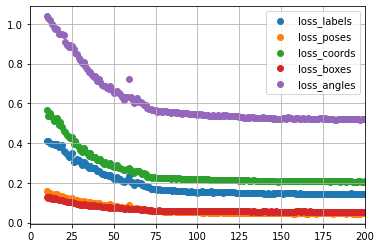

In [23]:
loss_labels = history['loss_labels']
loss_poses = history['loss_poses']
loss_coords = history['loss_coords']
loss_boxes = history['loss_boxes']
loss_angles = history['loss_angles']
index = range(len(loss_labels))

plt.scatter(index[10:], loss_labels[10:])
plt.scatter(index[10:], loss_poses[10:])
plt.scatter(index[10:], loss_coords[10:])
plt.scatter(index[10:], loss_boxes[10:])
plt.scatter(index[10:], loss_angles[10:])
plt.legend(["loss_labels", "loss_poses", "loss_coords", "loss_boxes", "loss_angles"])
plt.xlim([0,200])

plt.grid()

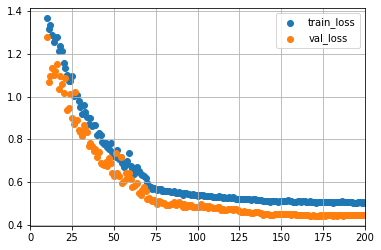

In [24]:
train_loss = history['train_loss']
val_loss = history['val_loss']
plt.scatter(index[10:], train_loss[10:])
plt.scatter(index[10:], val_loss[10:])
plt.legend(["train_loss", "val_loss"])
plt.xlim([0,200])
plt.grid()

# Inference with validation data

In [25]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.eval()
state_dict = torch.load("../model/0214_epoch184_evalLoss0.44152.pth")
model.load_state_dict(state_dict)

Using cache found in /home/takeshi/.cache/torch/hub/facebookresearch_detr_master


<All keys matched successfully>

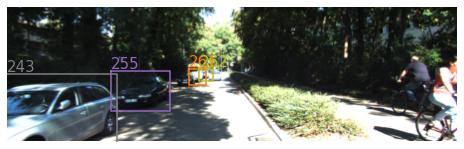

In [28]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib.patches as pat

def draw2Dbb(PILImage, thresh=.5):
    logit_thresh = thresh
    img = PILImage
    #img = ImageOps.mirror(img)
    img = transforms.Resize([135,450])(img)
    img = tf.to_tensor(img)

    output = model(img[None])
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}

    isVehicle = np.logical_and(output["pred_logits"][:,0]>output["pred_logits"][:,1],
                               output["pred_logits"][:,0]>logit_thresh)
    
    a = output["pred_angles"]
    angles = (np.arctan2(a[:,0],a[:,1])*180/np.pi)%360

    imgshow = np.rollaxis(np.array(img),0,3)
    ax.imshow(imgshow)
    coord = np.array(output["pred_boxes"])*np.array([imgshow.shape[1],imgshow.shape[0]*10/3]*2)
    cx, cy = coord[:,0], coord[:,1]
    w, h = coord[:,2], coord[:,3]
    x0, x1 = cx-.5*w, cx+.5*w
    y0, y1 = cy-.5*h, cy+.5*h
    for i, flag in enumerate(isVehicle):
        if flag:
            ax.plot([x0[i],x0[i],x1[i],x1[i],x0[i]],[y0[i],y1[i],y1[i],y0[i],y0[i]], color=cycle[i%10])
            ax.text(max(x0[i],0), y0[i]-2, int(angles[i]), size=15, color=cycle[i%10])
    ax.set_xlim([0,img.shape[2]])
    ax.set_ylim([img.shape[1],0])
    ax.axis("off")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

my_dpi = 72
fig, ax = plt.subplots(figsize=(450/my_dpi, 135/my_dpi), dpi=my_dpi)
img = vehicleAug.getPILImg(val_list[i+25])
draw2Dbb(img, thresh=.7)

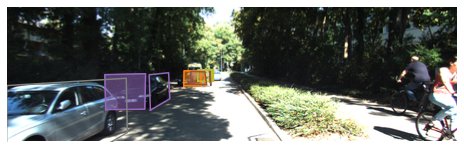

In [29]:
def draw3Dbb(PILImage, thresh=.5):

    poseThresh = .5
    
    img = PILImage
    #img = ImageOps.mirror(img)
    img = transforms.Resize([135,450], interpolation=Image.LANCZOS)(img)
    img = tf.to_tensor(img)

    output = model(img[None])
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output["pred_poses"] = output["pred_poses"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}

    logits = output["pred_logits"]
    isVehicle = np.logical_and(logits[:,0]>logits[:,1],
                               logits[:,0]>thresh)
    FrontOrRear = output["pred_coords"][:,:8].reshape([-1,4,2])*np.array([450,135])
    LeftOrRight = output["pred_coords"][:,8:].reshape([-1,4,2])*np.array([450,135])
    pose = output["pred_poses"]

    ax.imshow(np.rollaxis(np.array(img),0,3))
    for i in range(FrontOrRear.shape[0]):
        if isVehicle[i] and pose[i,1]>poseThresh:
            ax.plot(LeftOrRight[i,[0,1,3,2,0],0], LeftOrRight[i,[0,1,3,2,0],1], color=cycle[i%10])
        if isVehicle[i] and pose[i,0]>poseThresh:
            ax.plot(FrontOrRear[i,[0,1,3,2,0],0], FrontOrRear[i,[0,1,3,2,0],1], color=cycle[i%10])
            ax.add_patch(pat.Polygon(xy = [(FrontOrRear[i,0,0], FrontOrRear[i,0,1]),
                                            (FrontOrRear[i,1,0], FrontOrRear[i,1,1]),
                                            (FrontOrRear[i,3,0], FrontOrRear[i,3,1]),
                                            (FrontOrRear[i,2,0], FrontOrRear[i,2,1]),],
                                            fc = cycle[i%10], ec = cycle[i%10], alpha=0.5))
    
    ax.set_xlim([0,img.shape[2]])
    ax.set_ylim([img.shape[1],0])
    ax.axis("off")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

my_dpi = 72
fig, ax = plt.subplots(figsize=(450/my_dpi, 135/my_dpi), dpi=my_dpi)
img = vehicleAug.getPILImg(val_list[i+25])
draw3Dbb(img, thresh=.5)

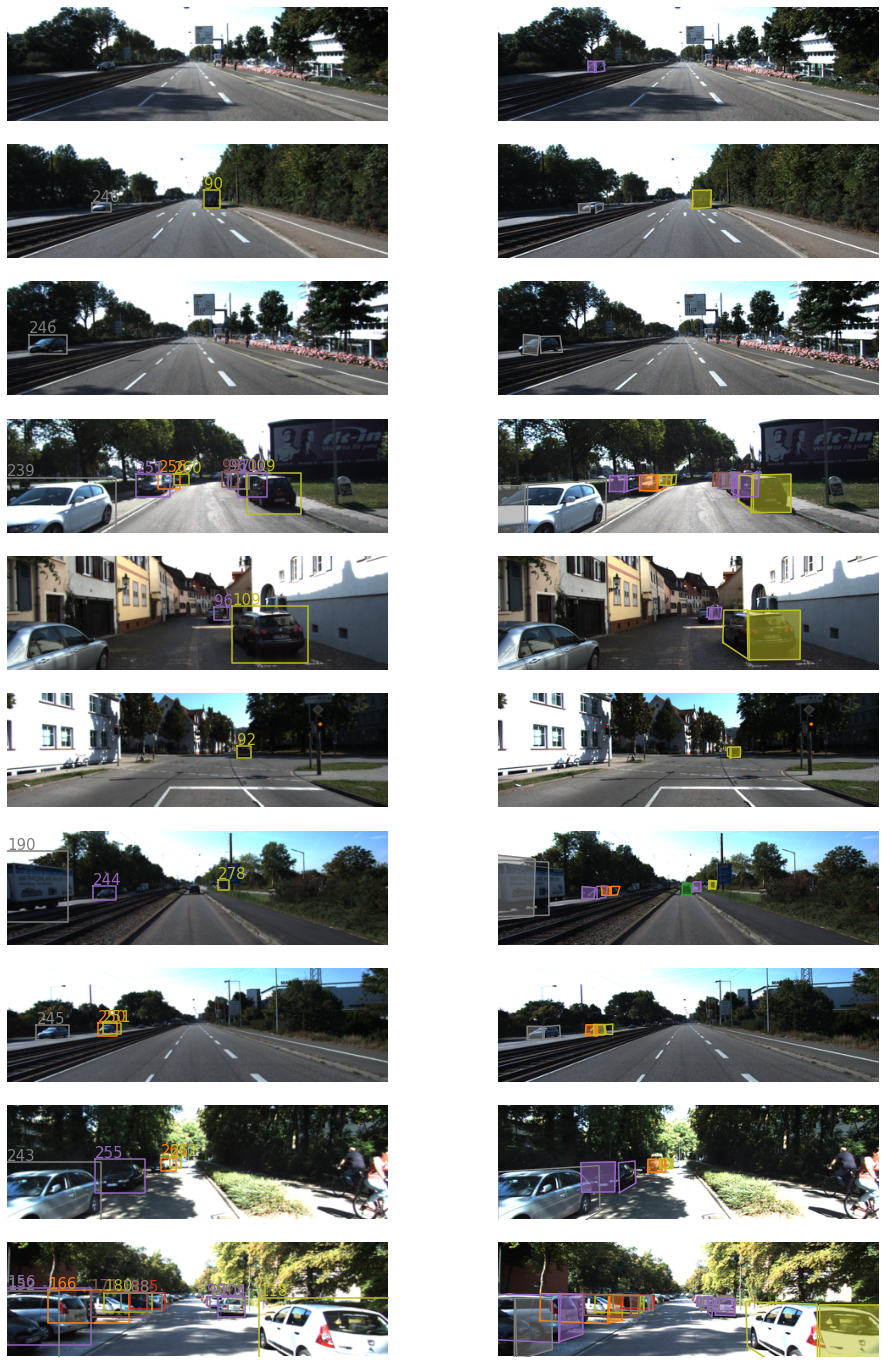

In [30]:
n = 10
fig, axs = plt.subplots(n, 2, figsize=(450/my_dpi*2, 135/my_dpi*n), dpi=my_dpi)
for i in range(n):
    img = vehicleAug.getPILImg(val_list[i+25])
    ax = axs[i][0]
    draw2Dbb(img, thresh=.7)
    ax = axs[i][1]
    draw3Dbb(img, thresh=.7)

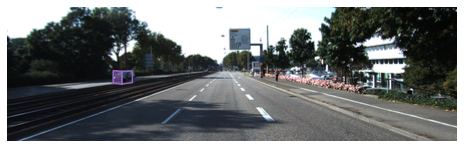

In [31]:
def drawInference(PILImage, thresh=.5):

    poseThresh = .5
    
    img = PILImage
    #img = ImageOps.mirror(img)
    img = transforms.Resize([135,450], interpolation=Image.LANCZOS)(img)
    img = tf.to_tensor(img)

    output = model(img[None])
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output["pred_poses"] = output["pred_poses"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}

    logits = output["pred_logits"]
    isVehicle = np.logical_and(logits[:,0]>logits[:,1],
                               logits[:,0]>thresh)
    FrontOrRear = output["pred_coords"][:,:8].reshape([-1,4,2])*np.array([450,135])
    LeftOrRight = output["pred_coords"][:,8:].reshape([-1,4,2])*np.array([450,135])
    pose = output["pred_poses"]
    angle_d = np.arctan2(output["pred_angles"][:,0],output["pred_angles"][:,1])*180/np.pi
    
    ## adjust 3D bounding box
    LeftOrRight[:,[0,1],0] = np.mean(LeftOrRight[:,[0,1],0], axis=1, keepdims=True)
    LeftOrRight[:,[2,3],0] = np.mean(LeftOrRight[:,[2,3],0], axis=1, keepdims=True)
    FrontOrRear[:,[0,1],0] = np.mean(FrontOrRear[:,[0,1],0], axis=1, keepdims=True)
    FrontOrRear[:,[2,3],0] = np.mean(FrontOrRear[:,[2,3],0], axis=1, keepdims=True)
    # jadge if left or right side is visible based on the angle estimation
    unvisibleSide = np.logical_and(-0.087<np.cos(angle_d/180*np.pi),np.cos(angle_d/180*np.pi)<0.087)
    pose[unvisibleSide,1] = 0
    # jadge if front or rear side is visible based on the angle estimation
    unvisibleFront = np.logical_and(-0.087<np.sin(angle_d/180*np.pi),np.sin(angle_d/180*np.pi)<0.087)
    pose[unvisibleFront,0] = 0
    # jadge if left or right side is located on the RIGHT side of the front or rear side
    isSideRight = np.logical_or(
                    np.logical_and(0.087<=np.cos(angle_d/180*np.pi),0.087<=np.sin(angle_d/180*np.pi)),
                    np.logical_and(np.cos(angle_d/180*np.pi)<=-0.087,np.sin(angle_d/180*np.pi)<=-0.087)
                    )
    x = (LeftOrRight[isSideRight,0,0] + FrontOrRear[isSideRight,2,0])/2
    LeftOrRight[isSideRight,0,0], LeftOrRight[isSideRight,1,0] = x, x
    FrontOrRear[isSideRight,2,0], FrontOrRear[isSideRight,3,0] = x, x
    y1 = (LeftOrRight[isSideRight,1,1] + FrontOrRear[isSideRight,3,1])/2
    LeftOrRight[isSideRight,1,1] = y1
    FrontOrRear[isSideRight,3,1] = y1
    y2 = (LeftOrRight[isSideRight,0,1] + FrontOrRear[isSideRight,2,1])/2
    LeftOrRight[isSideRight,0,1] = y2
    FrontOrRear[isSideRight,2,1] = y2
    # jadge if left or right side is located on the LEFT side of the front or rear side
    isSideRight = np.logical_or(
                    np.logical_and(0.087<=np.cos(angle_d/180*np.pi),np.sin(angle_d/180*np.pi)<=-0.087),
                    np.logical_and(np.cos(angle_d/180*np.pi)<=-0.087,0.087<=np.sin(angle_d/180*np.pi))
                    )
    x = (LeftOrRight[isSideRight,2,0] + FrontOrRear[isSideRight,0,0])/2
    LeftOrRight[isSideRight,2,0], LeftOrRight[isSideRight,3,0] = x, x
    FrontOrRear[isSideRight,0,0], FrontOrRear[isSideRight,1,0] = x, x
    y1 = (LeftOrRight[isSideRight,3,1] + FrontOrRear[isSideRight,1,1])/2
    LeftOrRight[isSideRight,3,1] = y1
    FrontOrRear[isSideRight,1,1] = y1
    y2 = (LeftOrRight[isSideRight,2,1] + FrontOrRear[isSideRight,0,1])/2
    LeftOrRight[isSideRight,2,1] = y2
    FrontOrRear[isSideRight,0,1] = y2

    ax.imshow(np.rollaxis(np.array(img),0,3))
    for i in range(FrontOrRear.shape[0]):
        if isVehicle[i] and pose[i,1]>poseThresh:
            ax.plot(LeftOrRight[i,[0,1,3,2,0],0], LeftOrRight[i,[0,1,3,2,0],1], color=cycle[i%10])
        if isVehicle[i] and pose[i,0]>poseThresh:
            ax.plot(FrontOrRear[i,[0,1,3,2,0],0], FrontOrRear[i,[0,1,3,2,0],1], color=cycle[i%10])
            ax.add_patch(pat.Polygon(xy = [(FrontOrRear[i,0,0], FrontOrRear[i,0,1]),
                                            (FrontOrRear[i,1,0], FrontOrRear[i,1,1]),
                                            (FrontOrRear[i,3,0], FrontOrRear[i,3,1]),
                                            (FrontOrRear[i,2,0], FrontOrRear[i,2,1]),],
                                            fc = cycle[i%10], ec = cycle[i%10], alpha=0.5))
    
    ax.set_xlim([0,img.shape[2]])
    ax.set_ylim([img.shape[1],0])
    ax.axis("off")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

my_dpi = 72
fig, ax = plt.subplots(figsize=(450/my_dpi, 135/my_dpi), dpi=my_dpi)
img = vehicleAug.getPILImg(val_list[25])
drawInference(img, thresh=.5)

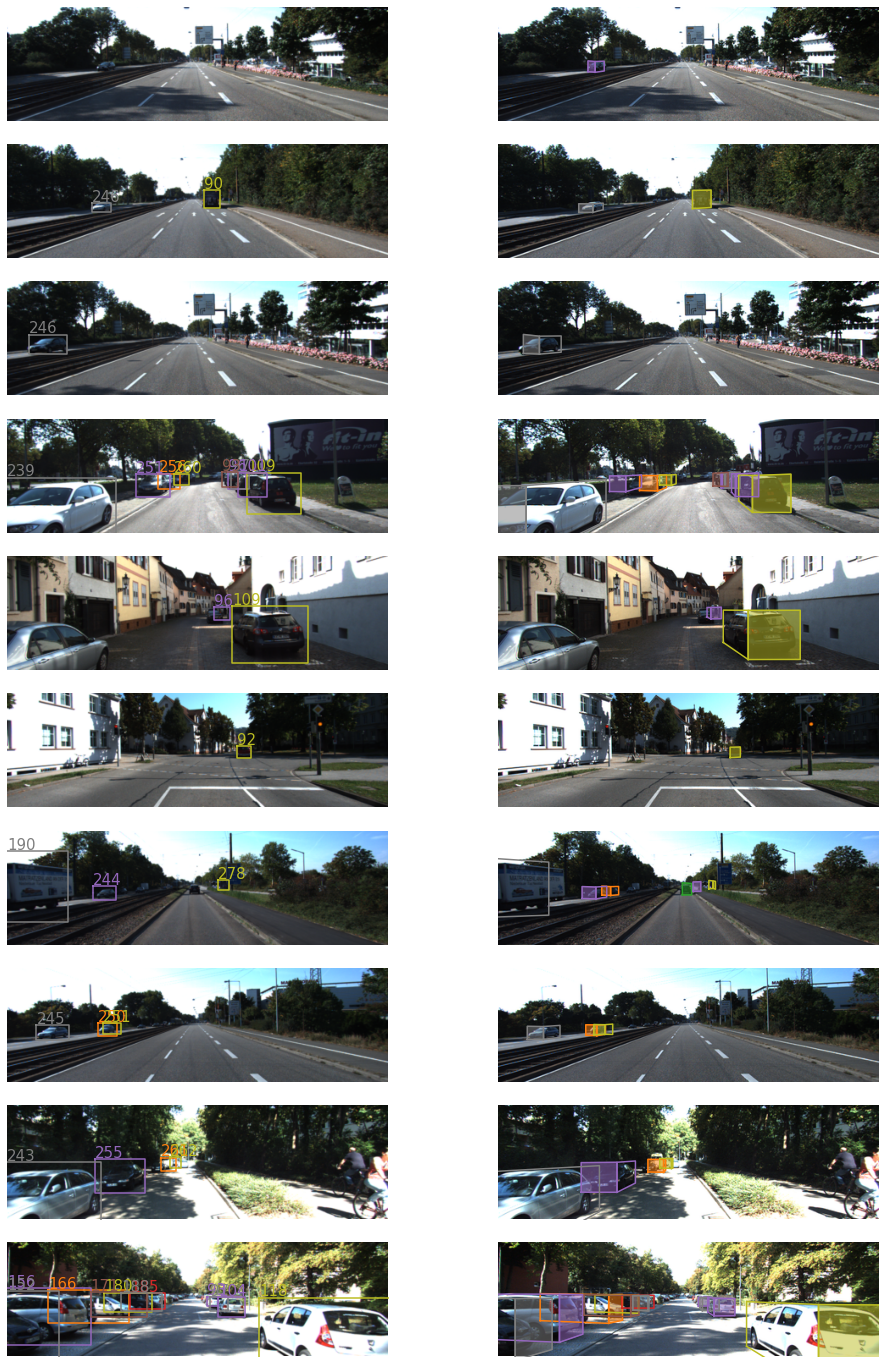

In [32]:
n = 10
fig, axs = plt.subplots(n, 2, figsize=(450/my_dpi*2, 135/my_dpi*n), dpi=my_dpi)
for i in range(n):
    img = vehicleAug.getPILImg(val_list[i+25])
    ax = axs[i][0]
    draw2Dbb(img, thresh=.7)
    ax = axs[i][1]
    drawInference(img, thresh=.7)

## export movie

In [33]:
from moviepy.editor import VideoClip, VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import HTML

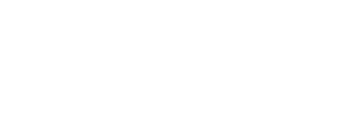

In [34]:
my_dpi = 72
#fig, ax = plt.subplots(figsize=(5, 2))
fig, ax = plt.subplots(figsize=(450/my_dpi, 135/my_dpi), dpi=my_dpi)
ax.axis("off")

def make_frame(img, thresh=.7):
    ax.clear()
    
    logit_thresh = thresh
    crop_t = 350
    crop_l = 300
    img = img[crop_t:int(crop_t+(1280-crop_l)/450*135),crop_l:,:]
    img = Image.fromarray(np.uint8(img))

    drawInference(img, thresh=.5)
    
    return mplfig_to_npimage(fig)

In [35]:
output = '../output/output_video_.mp4'
clip1 = VideoFileClip("../output/project_video.mp4")#.subclip(44,47)
clip = clip1.fl_image(make_frame)
clip.write_videofile(output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../output/output_video_.mp4.
Moviepy - Writing video ../output/output_video_.mp4



Moviepy - Done !
Moviepy - video ready ../output/output_video_.mp4
